## 11.1 扩散模型概述
扩散模型是一种流行的深度生成模型，它被广泛应用于图像生成和其他应用领域。
扩散模型背后的基本原理是，将复杂的图片或信息分解为简单的组成部分，然后通过逐步添加细节和复杂性来生成最终的输出。这个过程类似于自然界中的扩散现象，即分子从高浓度区域向低浓度区域转移并逐渐均匀分布。
在生成式人工智能中，扩散模型通常首先从一个随机噪声输入开始，然后通过多个阶段逐步添加信息，最终生成一个有序的输出。这个过程可以看作是在构建一个标签的过程，即从无序的噪声中逐步构建出有序的输出。
相比其他深度生成模型，如GAN和VAE，扩散模型具有一些优点。例如，GAN需要训练两个网络，即生成器和判别器，这可能会增加训练难度和计算资源要求。而VAE则要求对潜在变量进行近似推理，这可能会引入误差。相比之下，扩散模型更加简单直观，训练相对容易，且在很多应用场景中表现优异。

### 11.1.5正向扩散过程的数学细节

shape of s: (10000, 2)


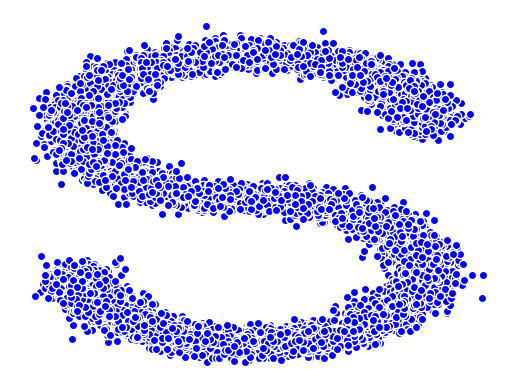

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

s_curve,_ = make_s_curve(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

print("shape of s:",np.shape(s_curve))

data = s_curve.T

fig,ax = plt.subplots()
ax.scatter(*data,color='blue',edgecolor='white');

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

In [23]:
dataset.shape

torch.Size([10000, 2])

In [24]:
dataset[:2]

tensor([[-0.1037,  0.0833],
        [ 0.1125, -0.0856]])

2、确定超参数的值

In [14]:
#定义时间步长为100
num_steps = 100

#制定每一步的beta，维度为100
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt等变量的值
alphas = 1-betas
#沿着第0个维度，进行累积乘法
alphas_prod = torch.cumprod(alphas,0)

#按行拼接，把张量1放在第一个位置
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


## [说明]
1、cumprod为cumulative product的意思，即累积乘法。
给定一个长度为N的向量$\{x_i\}_{i=1}^N$
得到$\{y_i\}_{i=1}^N$，其中$y_i=x_1\times x_2\times\cdots\times x_i$  
2、alphas_prod$=\prod_{i=1}^T{\alpha_i}$

In [34]:
betas = torch.linspace(-6,6,100)
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5
print(betas.shape)

torch.Size([100])


3、确定扩散过程任意时刻的采样值

In [15]:
#计算任意时刻的x采样值，基于x_0和重参数化
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    #x_0 与noise的形状相同
    noise = torch.randn_like(x_0)
    
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)#在x[0]的基础上添加噪声
    

### 【说明】  
$x_t=\sqrt{\bar{a_t}}x_0+\sqrt{1-\bar{a_t}}{\bar{z_t}}$  



4、演示原始数据分布加噪100步后的结果

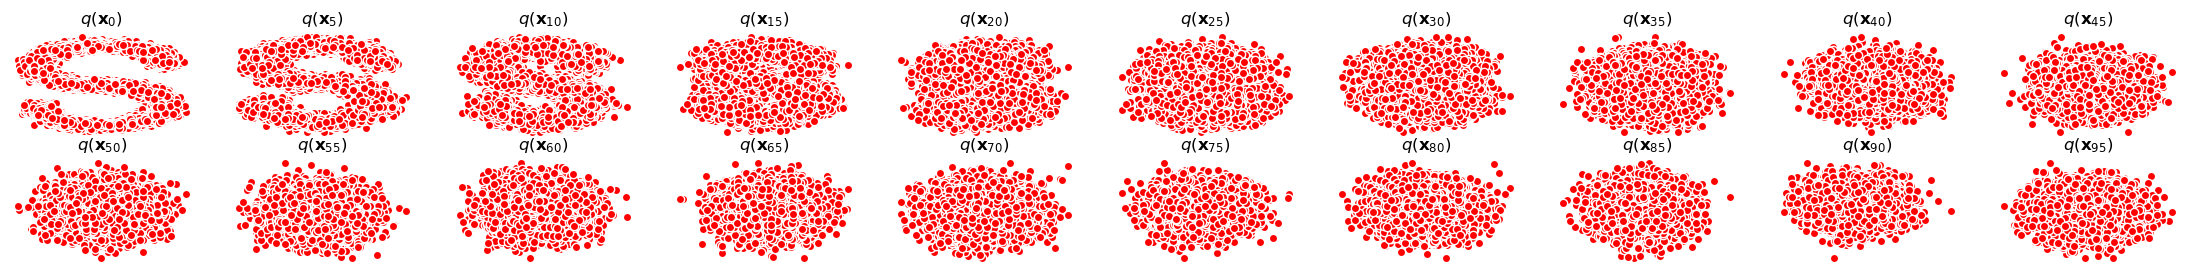

In [16]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

#共有10000个点，每个点包含两个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))#生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

### 11.1.6反向扩散过程的数学细节
如果说正向过程是加噪的过程，那么反向过程就是扩散的去噪推断过程。如果我们能够逐步得到逆转后的分布q(x_(t-1) |x_t)，就可以从完全的标准高斯分布x_T~Ν(0,I)还原出原图分布x_0。然而我们无法简单推断q(x_(t-1) |x_t)，因此我们使用深度学习模型（参数为θ，目前主流是U-Net+Attention的结构）去预测这样的一个逆向的分布p_θ。具体过程如图11-8所示。

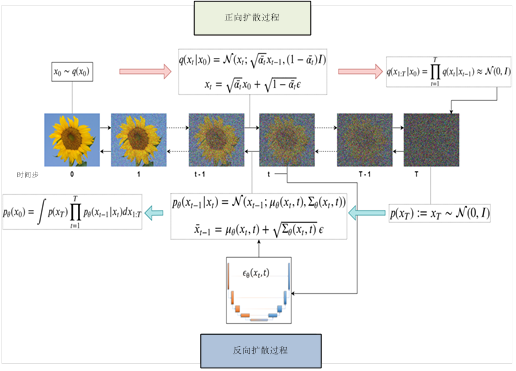
<center>图11-8 反向扩散过程的底层数学逻辑</center>  
这里关键用UNet网络预测在时间t输入x_t的输出值ϵ_θ (x_t,t)，最后通过去噪，得到p_θ (x_0)。为简便起见，这里用一个简单网络来预测ϵ_θ的网络结构，没有使用UNet网络。

In [18]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x,t):
#         x = x_0
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
            
        x = self.linears[-1](x)
        
        return x

DDPM每步训练是随机采样一个时间，为了当前时间t属于去噪过程中的哪一步，需要将当前t编码并传入网络，DDPM使用的Unet是时间条件UNet（time-condition Unet）。类似于Transformer的位置编码（positional embedding），DDPM采用正弦位置编码（Sinusoidal Positional Embeddings），既需要位置编码有界又需要两个时间步长之间的距离与句子长度无关。

In [22]:
#查看MLPD的网络结构，这里模拟U-Net网络结构
MLPD=MLPDiffusion(n_steps=100)
print(MLPD)

MLPDiffusion(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
  (step_embeddings): ModuleList(
    (0-2): 3 x Embedding(100, 128)
  )
)


### 11.1.7训练目标和损失函数
DDPM将loss进一步简化为:
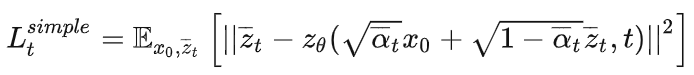

训练过程可以看做：

1）获取输入$x_0$ ，从$1\cdots T $随机采样一个t .

2) 从标准高斯分布采样一个噪声 $\bar{z_t}\sim N(0,I)$  

3)最小化函数：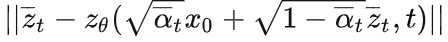

4)这里取$\beta_t=\delta_t^2$
 .

## 训练及采样算法如下
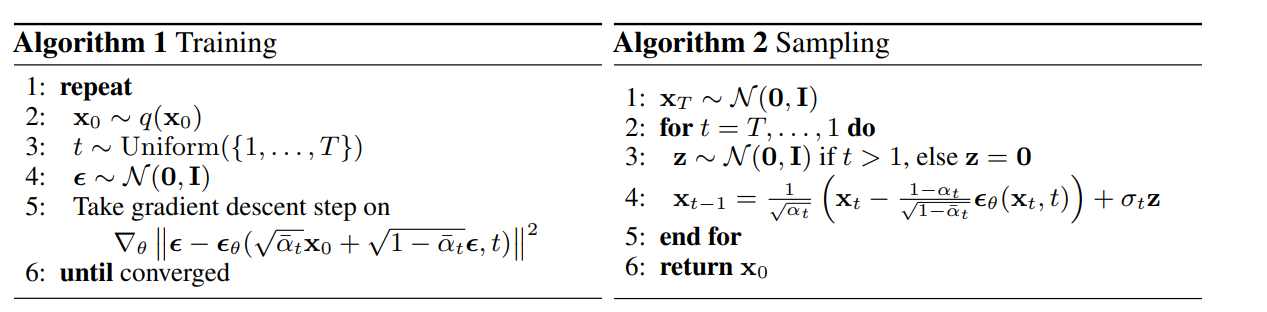

In [6]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t
    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t]
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音eps
    e = torch.randn_like(x_0)
    
    #构造模型的输入
    x = x_0*a+e*aml
    
    #送入模型，得到t时刻的随机噪声预测值(e_0)
    output = model(x,t.squeeze(-1))
    
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

In [26]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
for idx,x1 in enumerate(dataloader):
    x1
    break
batch_size = x1.shape[0]

In [27]:
x1.shape

torch.Size([128, 2])

In [30]:
t = torch.randint(0,100,size=(128//2,))
t = torch.cat([t,100-1-t],dim=0)
#t = t.unsqueeze(-1)

In [32]:
t[:2]

tensor([18, 38])

编写逆扩散采样函数（inference）
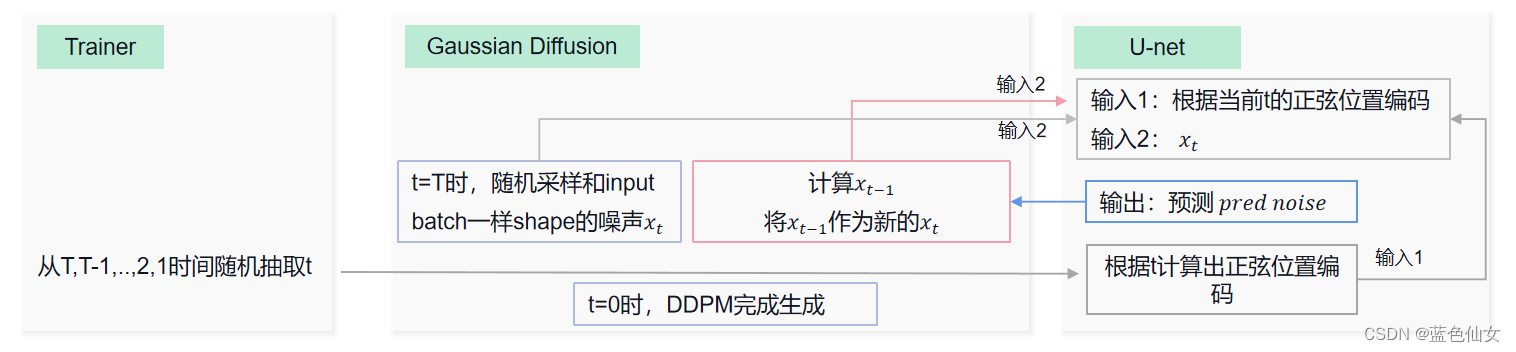

In [7]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

#### 开始训练模型，打印loss及中间重构效果
DDPM的trainer采用EMA（指数移动平均）优化，EMA不参与训练，只参与推理，比对变量直接赋值而言，移动平均得到的值在图像上更加平缓光滑，抖动性更小。

Training model...
tensor(0.7096, grad_fn=<MeanBackward0>)
tensor(0.4583, grad_fn=<MeanBackward0>)
tensor(0.2399, grad_fn=<MeanBackward0>)
tensor(0.5390, grad_fn=<MeanBackward0>)
tensor(0.2581, grad_fn=<MeanBackward0>)
tensor(0.2227, grad_fn=<MeanBackward0>)
tensor(0.3607, grad_fn=<MeanBackward0>)
tensor(0.4900, grad_fn=<MeanBackward0>)
tensor(0.1934, grad_fn=<MeanBackward0>)
tensor(0.3082, grad_fn=<MeanBackward0>)
tensor(0.2180, grad_fn=<MeanBackward0>)
tensor(0.3993, grad_fn=<MeanBackward0>)
tensor(0.4150, grad_fn=<MeanBackward0>)
tensor(0.1840, grad_fn=<MeanBackward0>)
tensor(0.3337, grad_fn=<MeanBackward0>)
tensor(0.2557, grad_fn=<MeanBackward0>)
tensor(0.4328, grad_fn=<MeanBackward0>)
tensor(0.3319, grad_fn=<MeanBackward0>)
tensor(0.6082, grad_fn=<MeanBackward0>)
tensor(0.4460, grad_fn=<MeanBackward0>)
tensor(0.5704, grad_fn=<MeanBackward0>)


C:\Users\wumgapp\AppData\Local\Temp\ipykernel_11884\2415299030.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.2139, grad_fn=<MeanBackward0>)
tensor(0.3440, grad_fn=<MeanBackward0>)
tensor(0.2188, grad_fn=<MeanBackward0>)
tensor(0.2056, grad_fn=<MeanBackward0>)
tensor(0.3367, grad_fn=<MeanBackward0>)
tensor(0.7162, grad_fn=<MeanBackward0>)
tensor(0.3902, grad_fn=<MeanBackward0>)
tensor(0.2898, grad_fn=<MeanBackward0>)
tensor(0.4315, grad_fn=<MeanBackward0>)
tensor(0.3244, grad_fn=<MeanBackward0>)
tensor(0.3018, grad_fn=<MeanBackward0>)
tensor(0.2567, grad_fn=<MeanBackward0>)
tensor(0.2832, grad_fn=<MeanBackward0>)
tensor(0.4907, grad_fn=<MeanBackward0>)
tensor(0.3297, grad_fn=<MeanBackward0>)
tensor(0.3049, grad_fn=<MeanBackward0>)
tensor(0.1822, grad_fn=<MeanBackward0>)
tensor(0.1831, grad_fn=<MeanBackward0>)
tensor(0.2273, grad_fn=<MeanBackward0>)


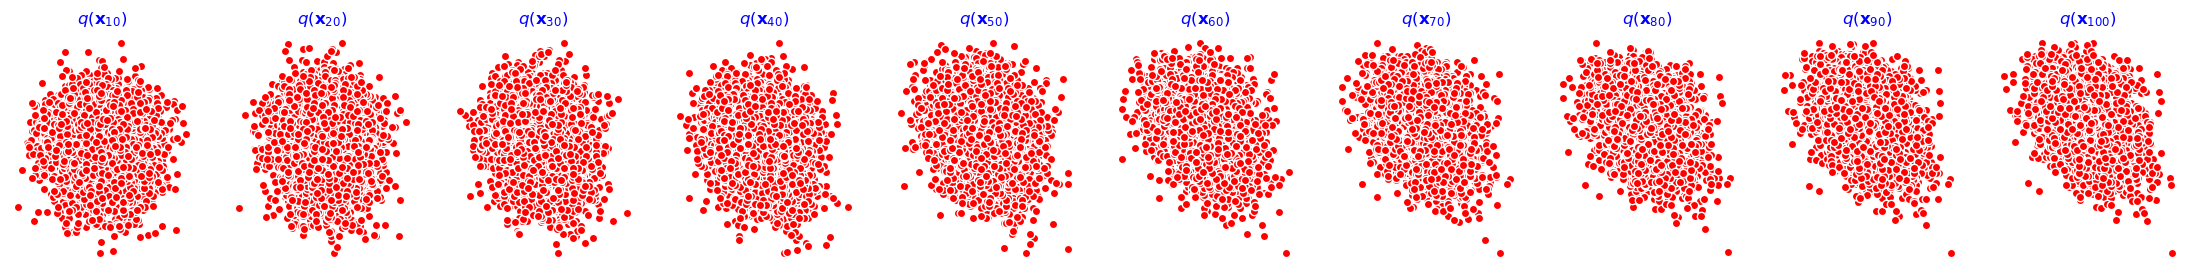

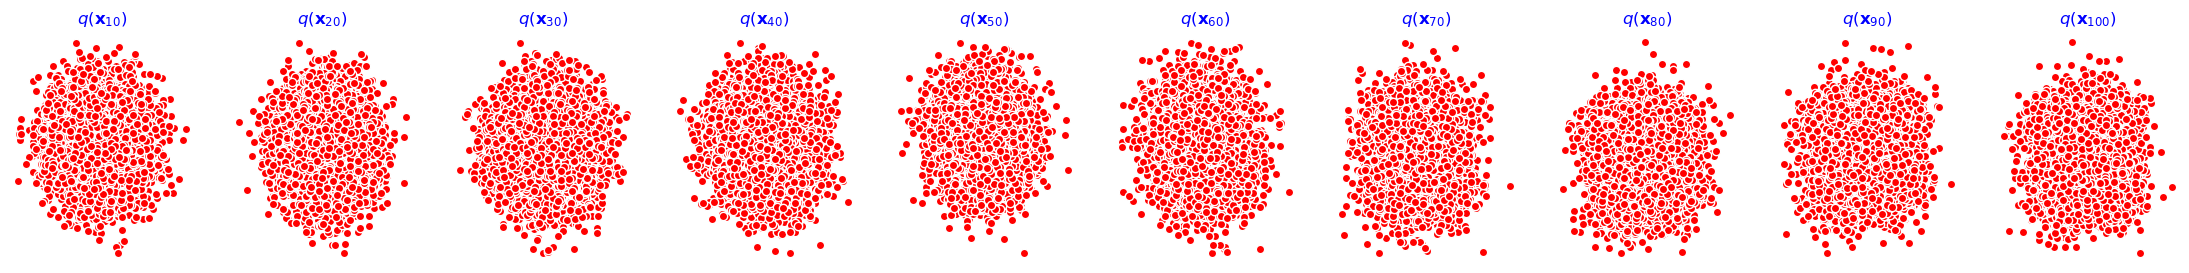

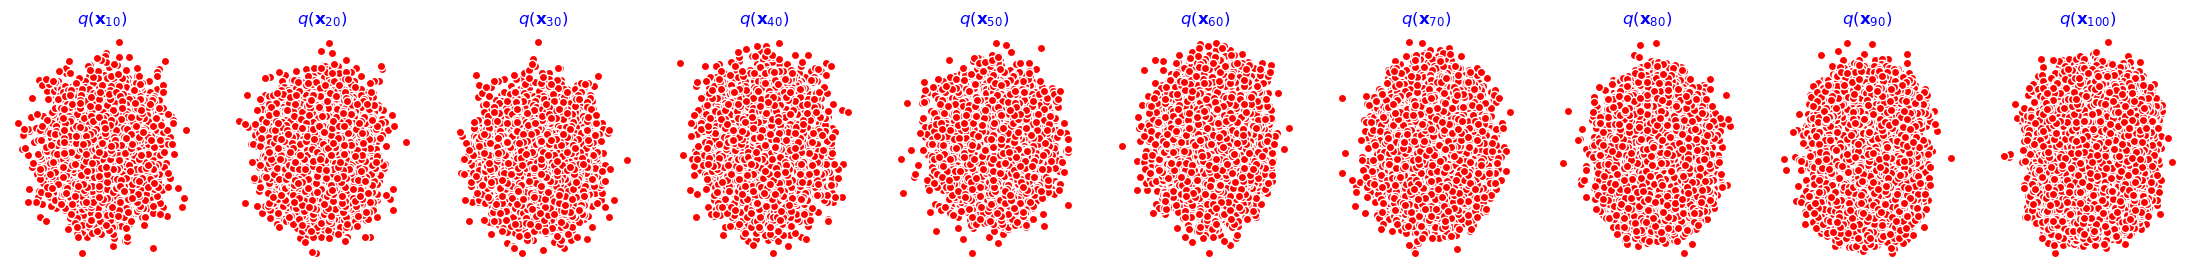

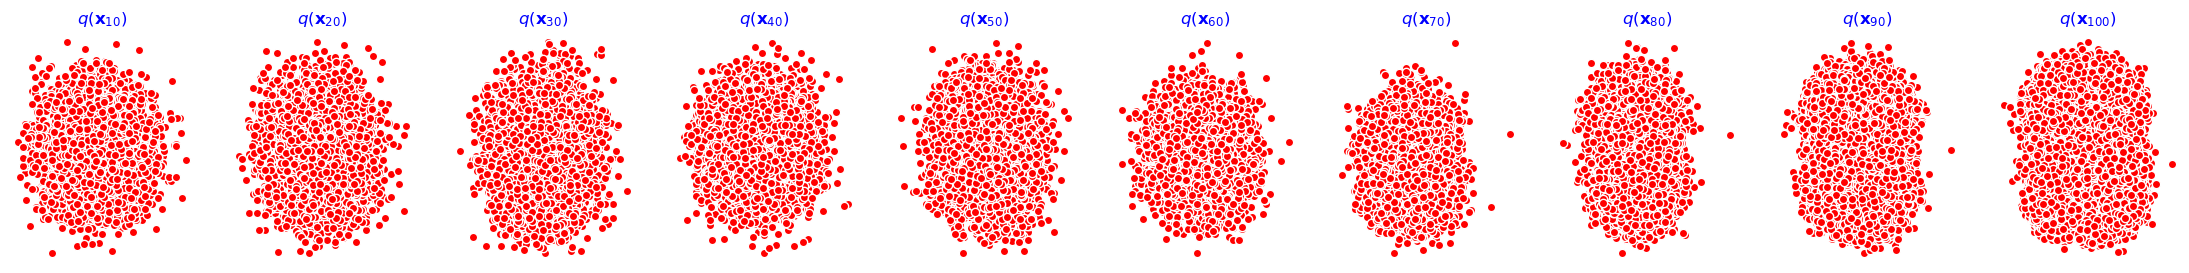

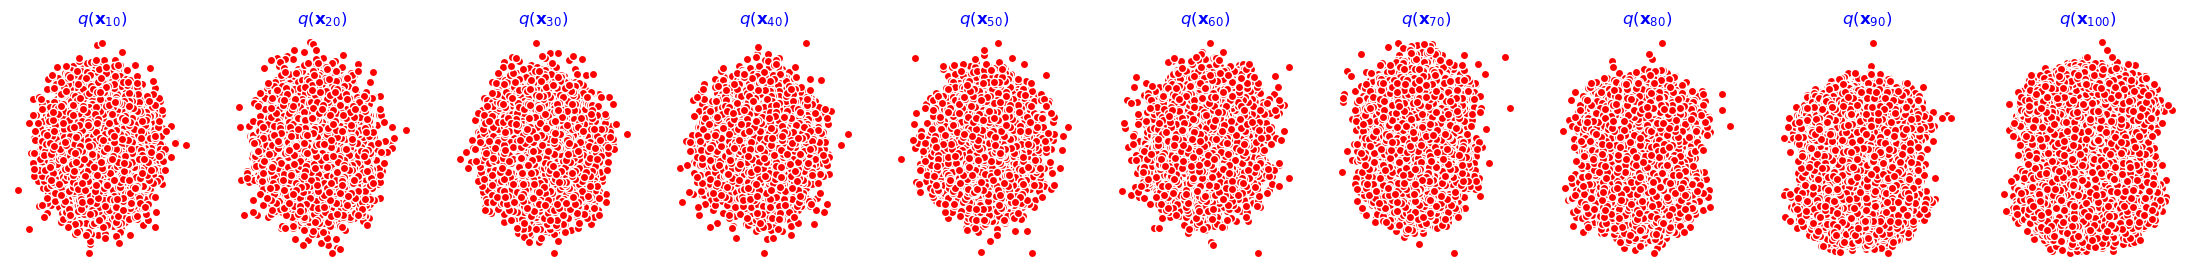

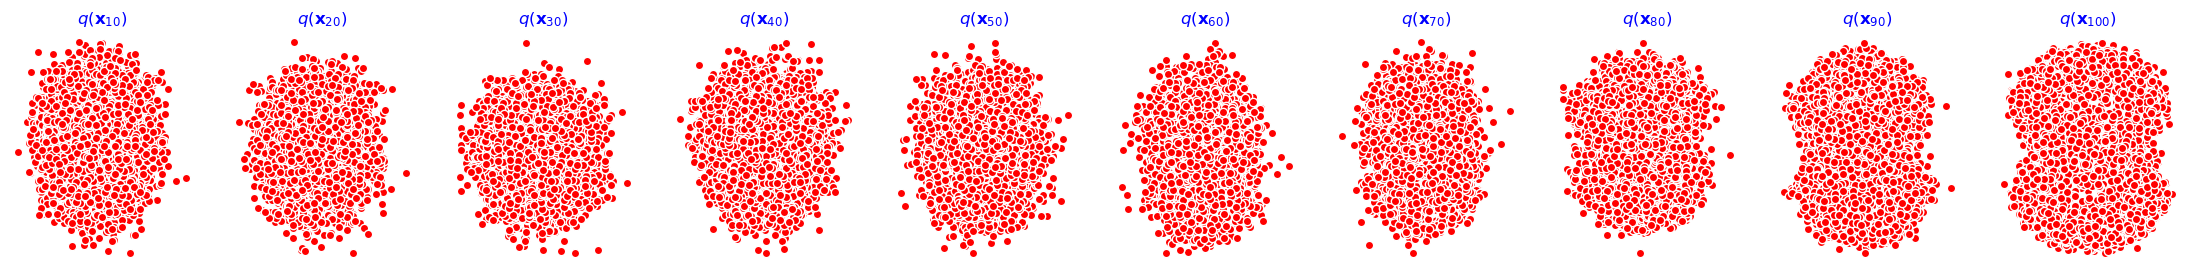

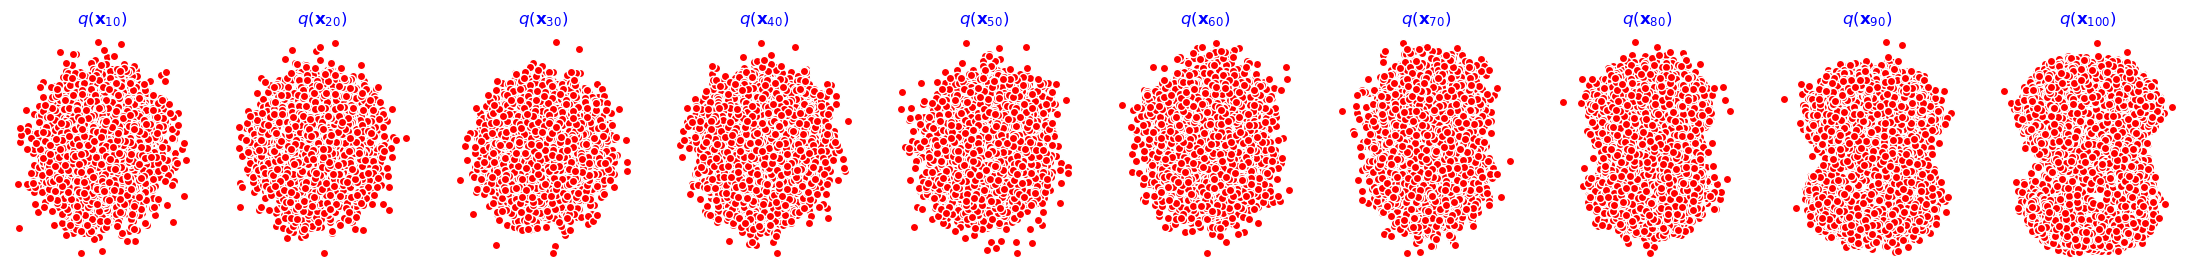

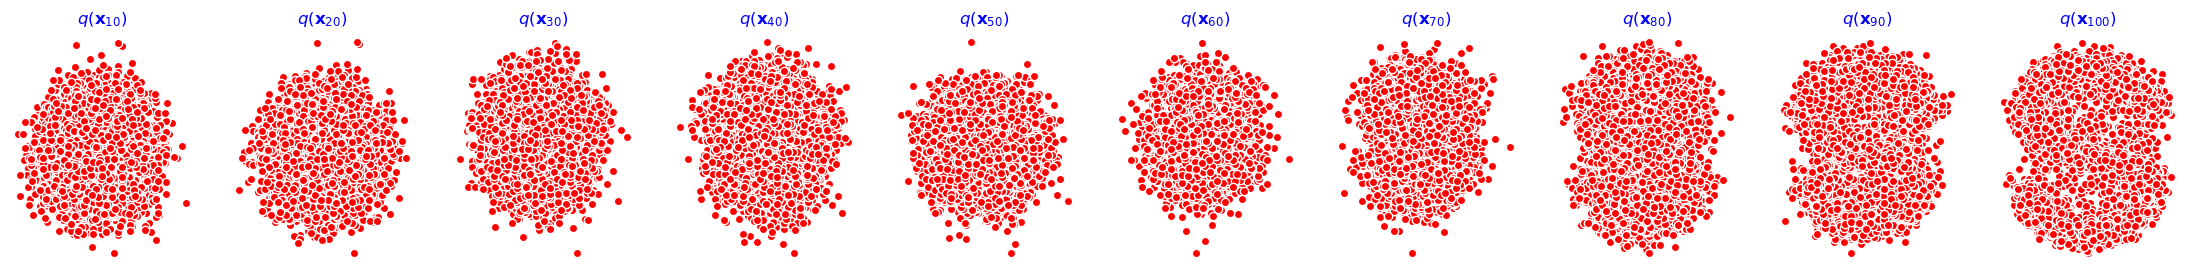

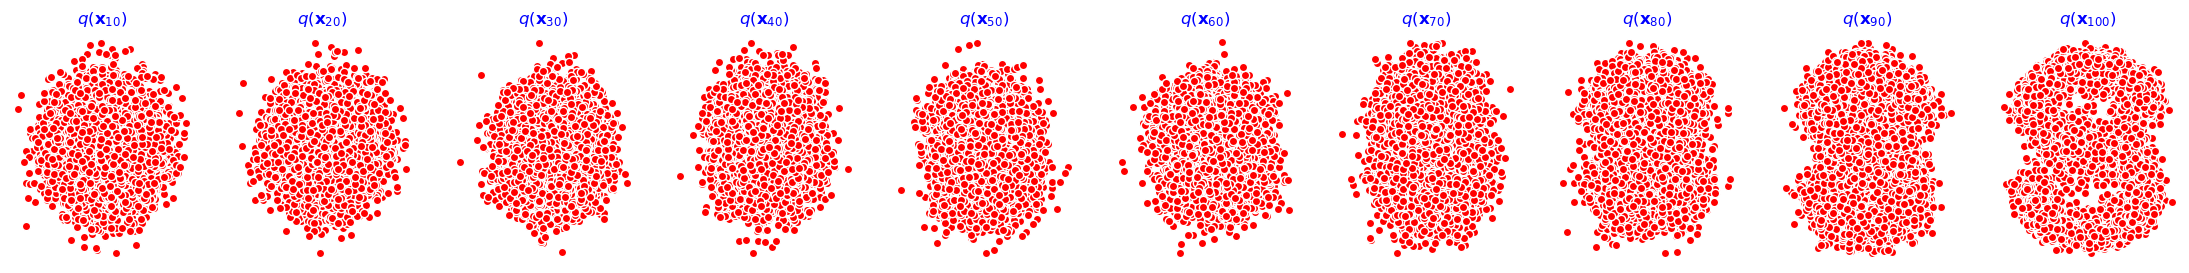

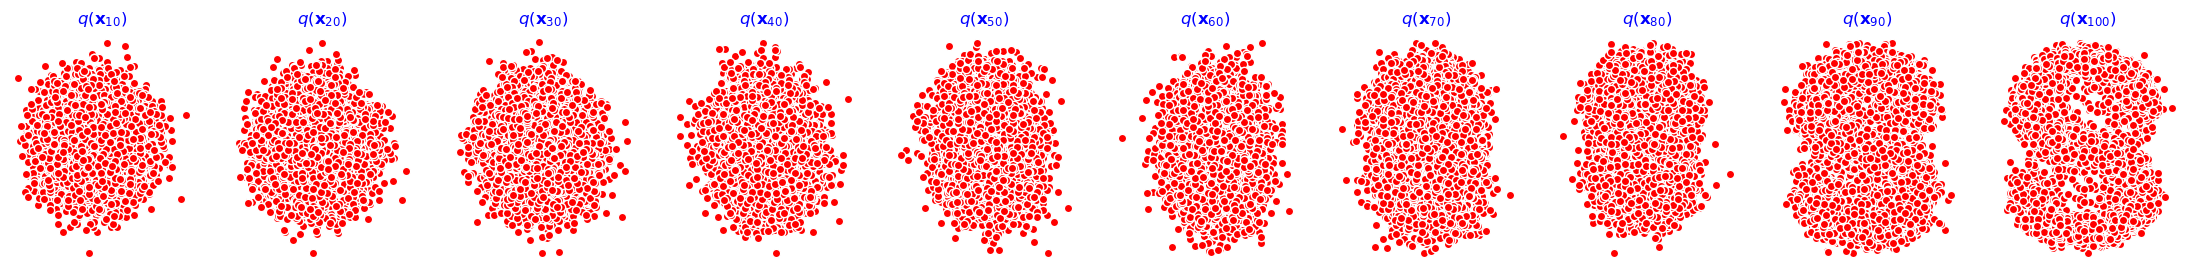

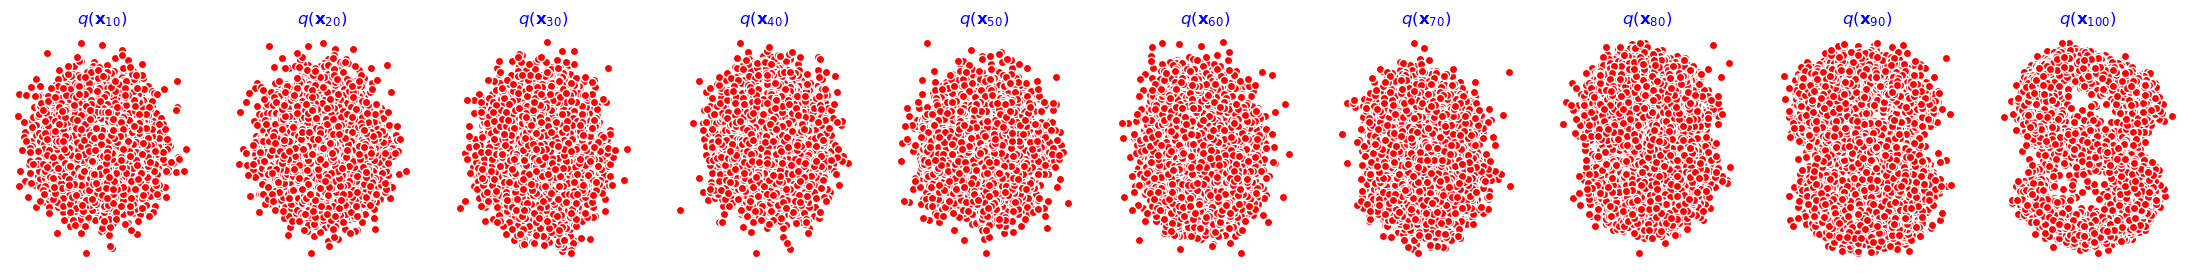

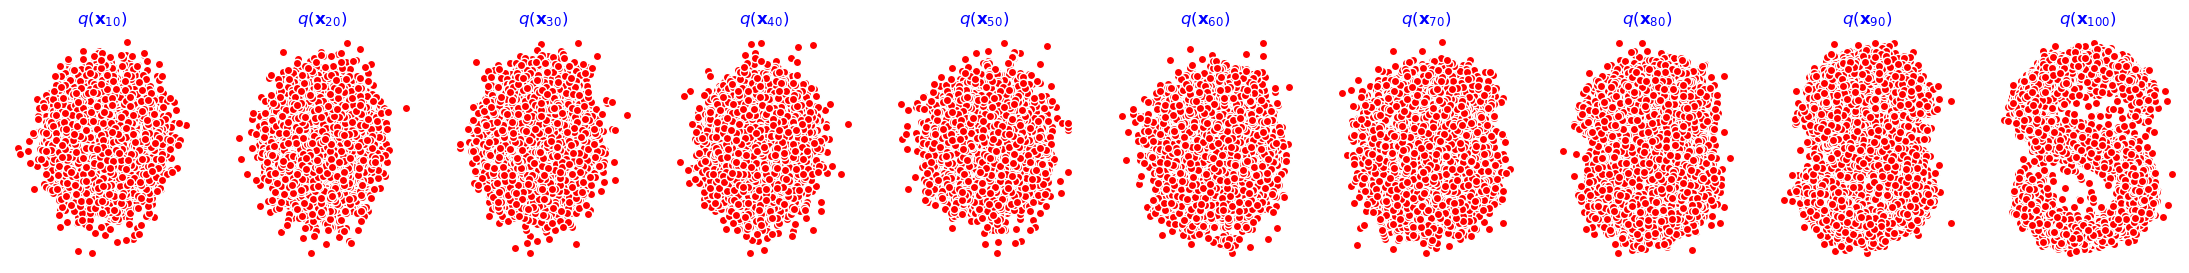

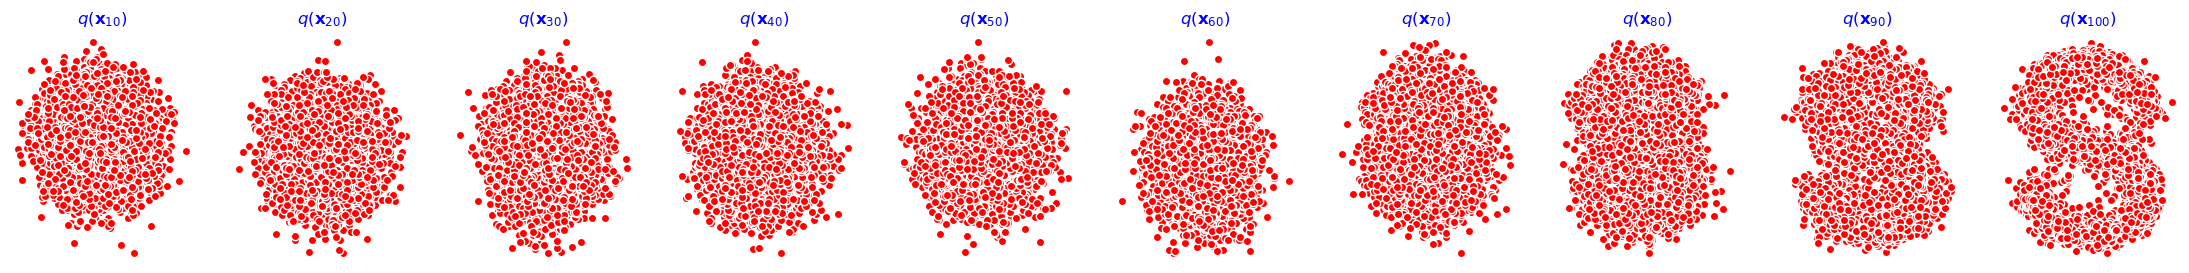

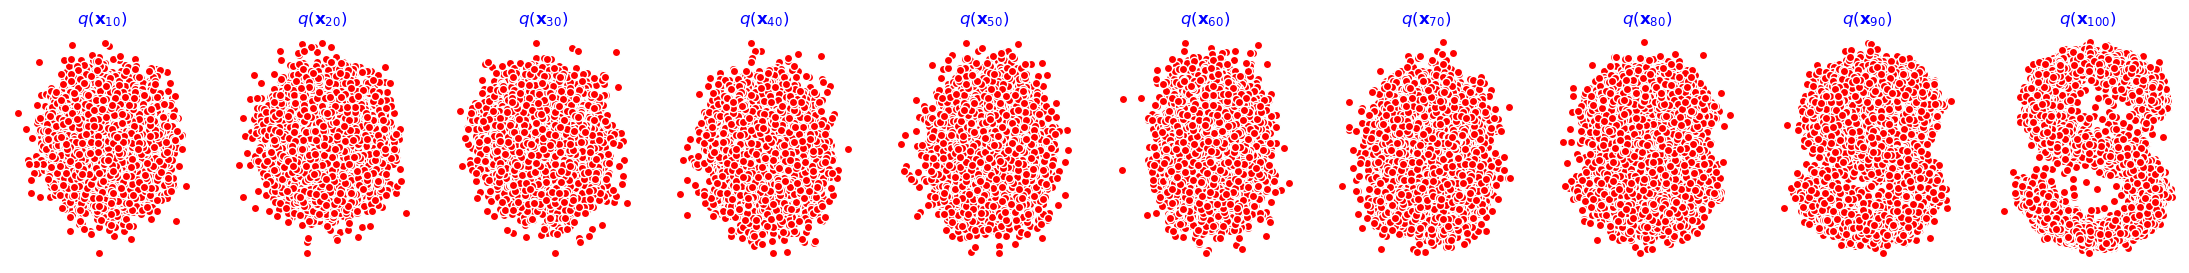

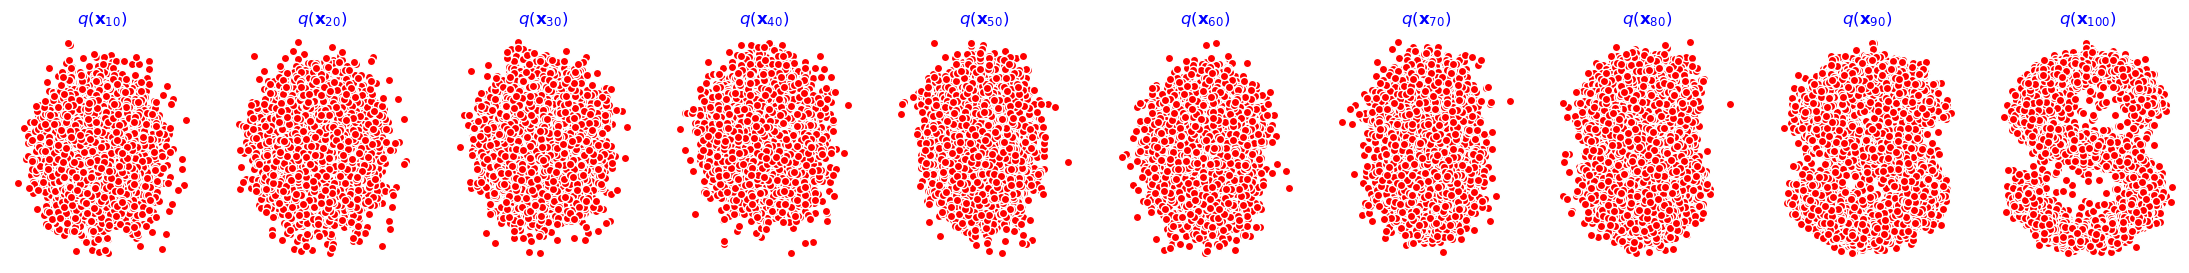

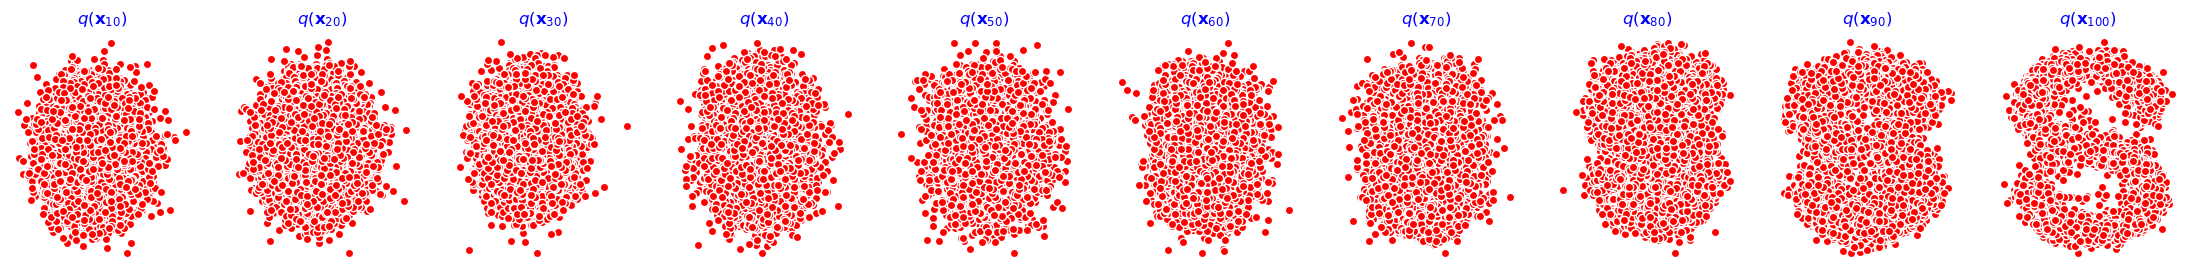

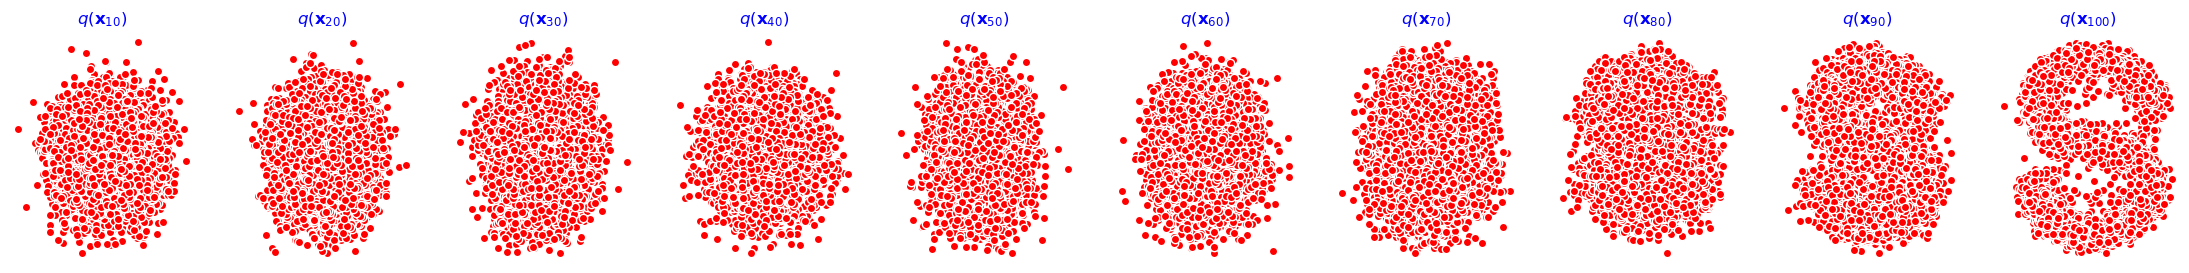

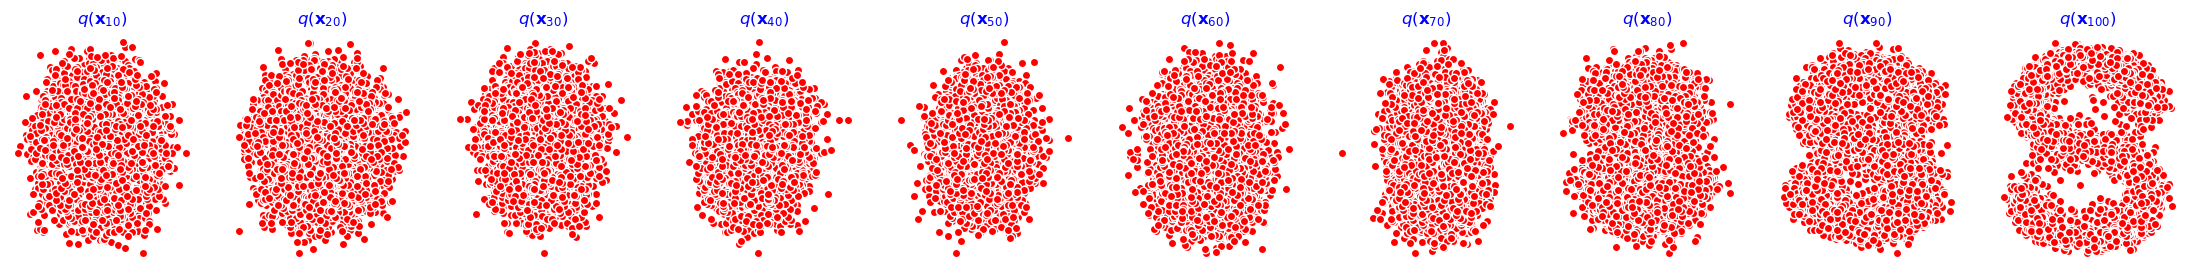

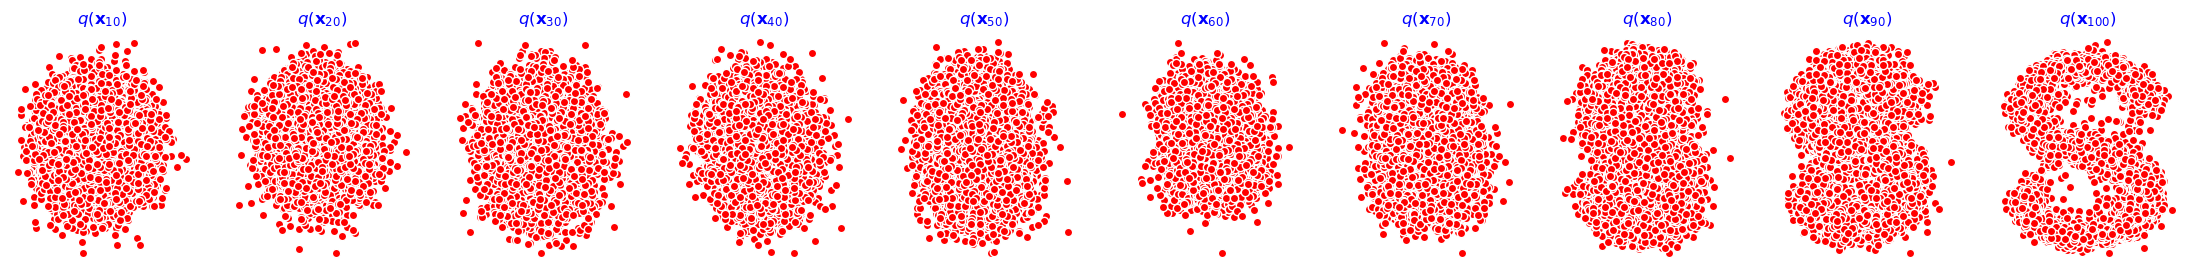

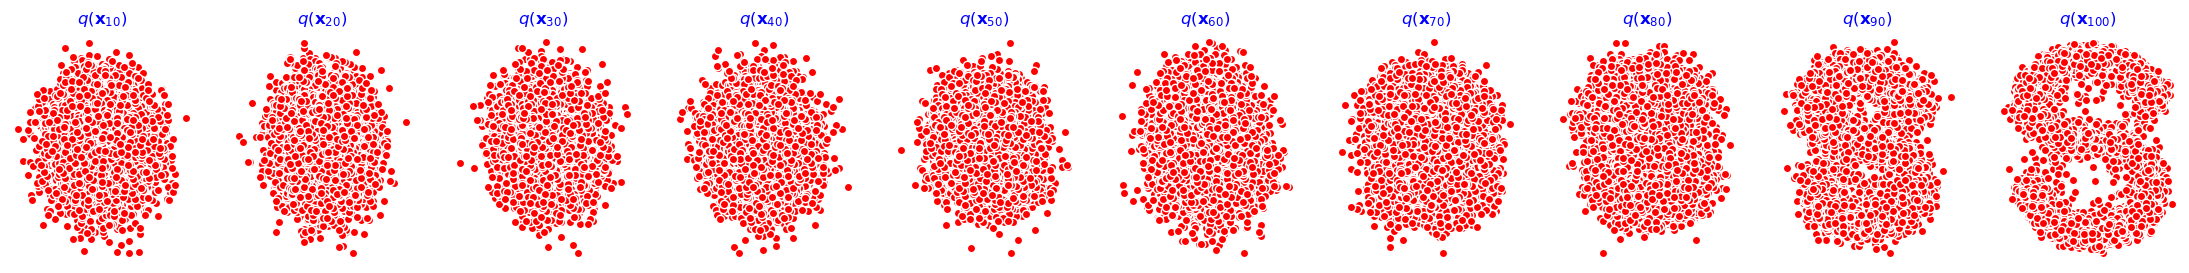

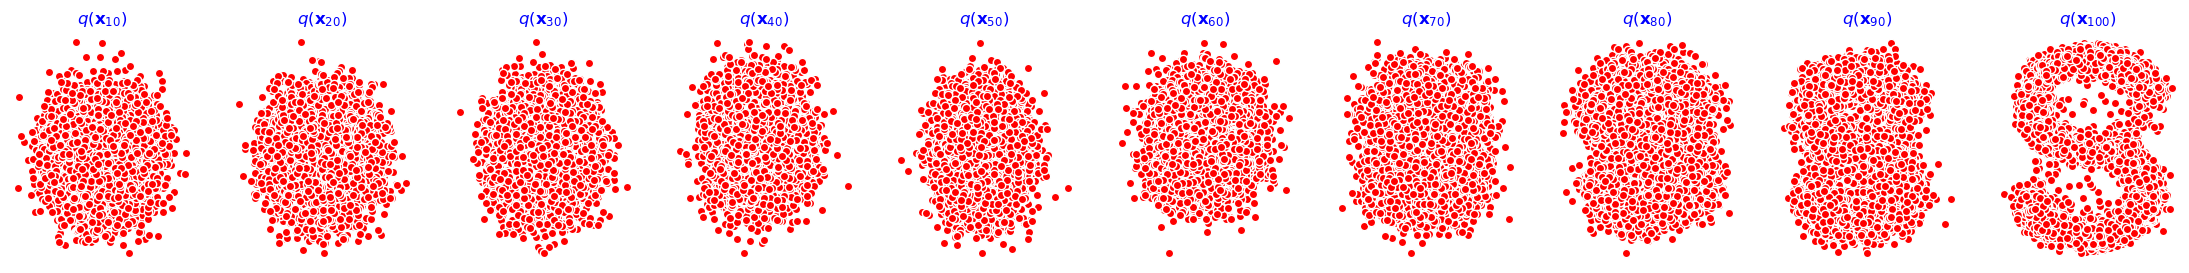

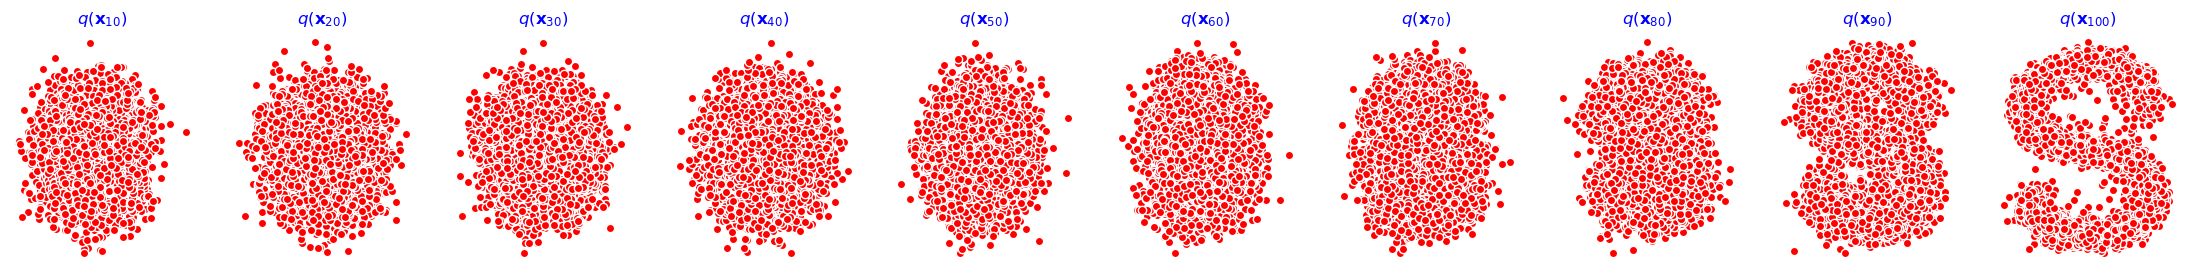

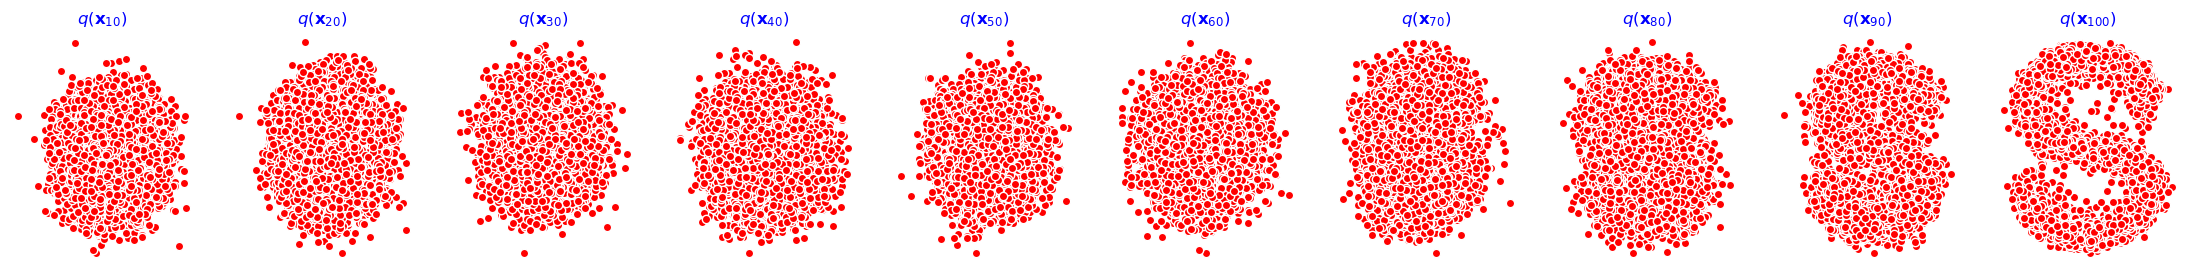

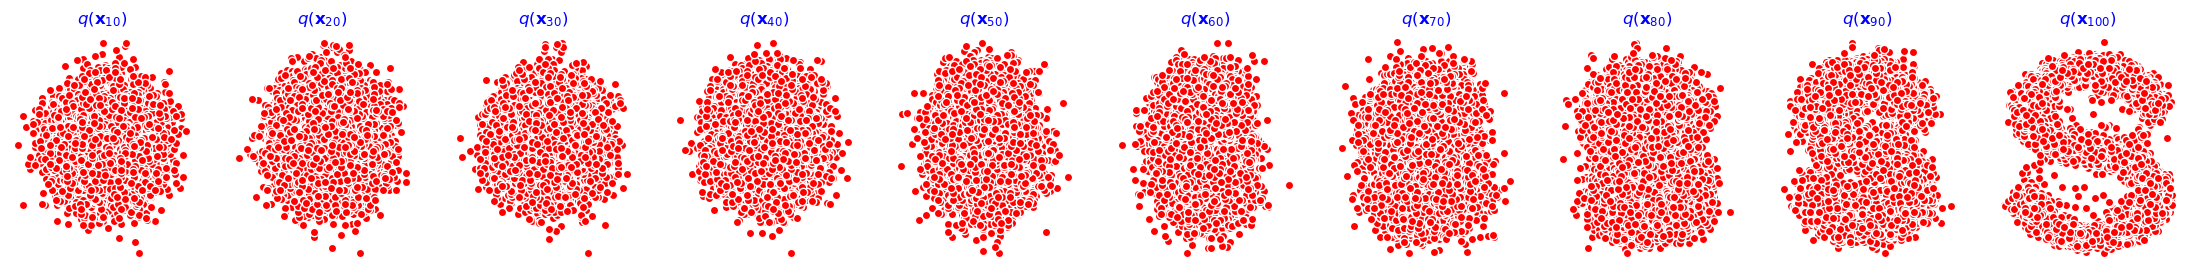

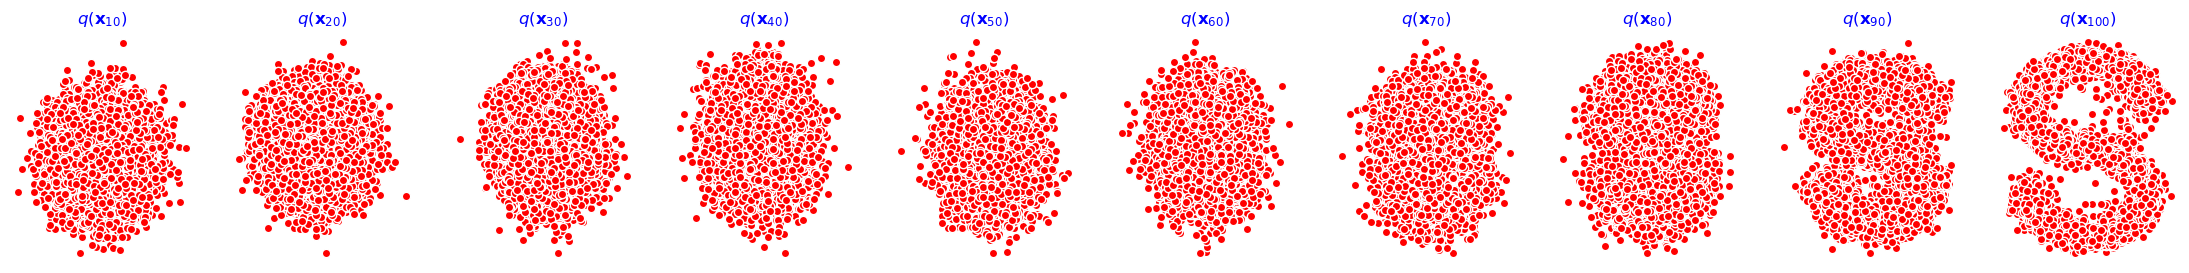

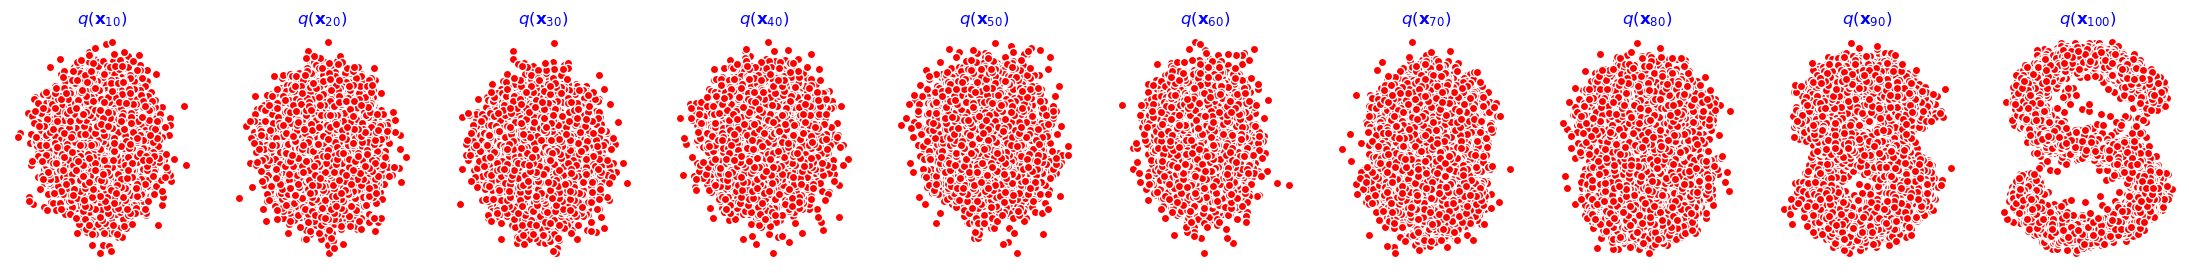

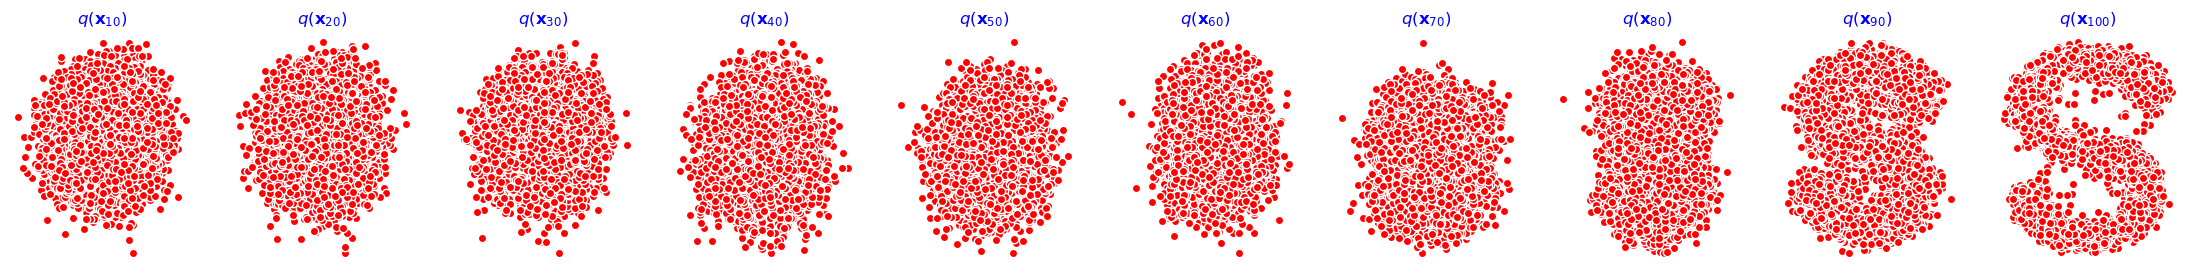

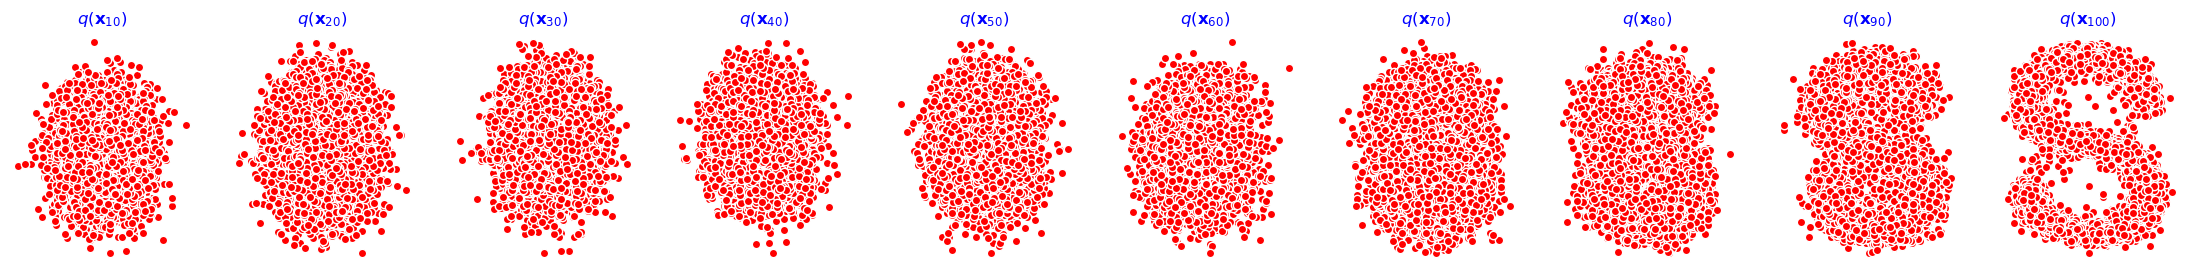

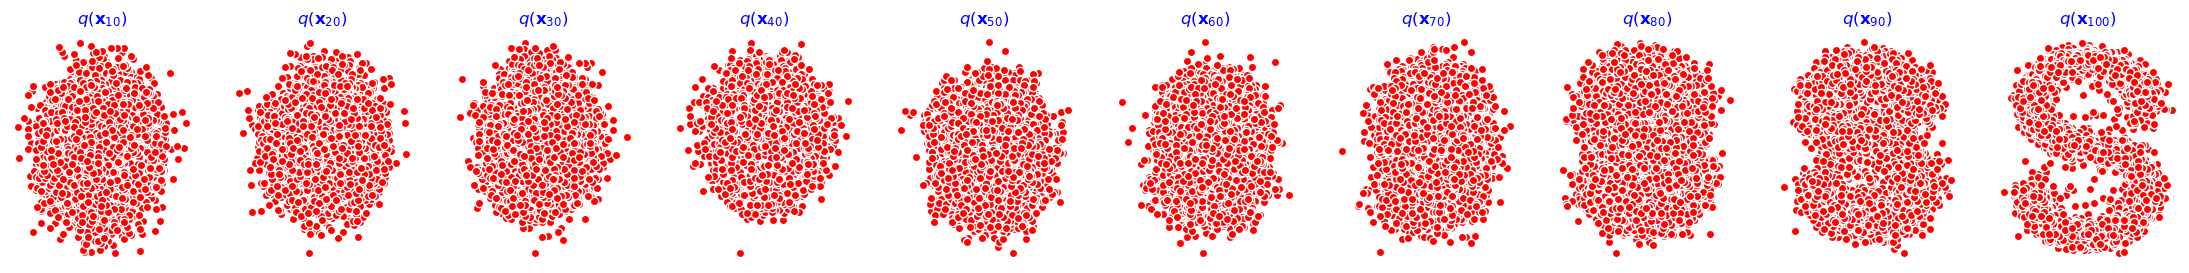

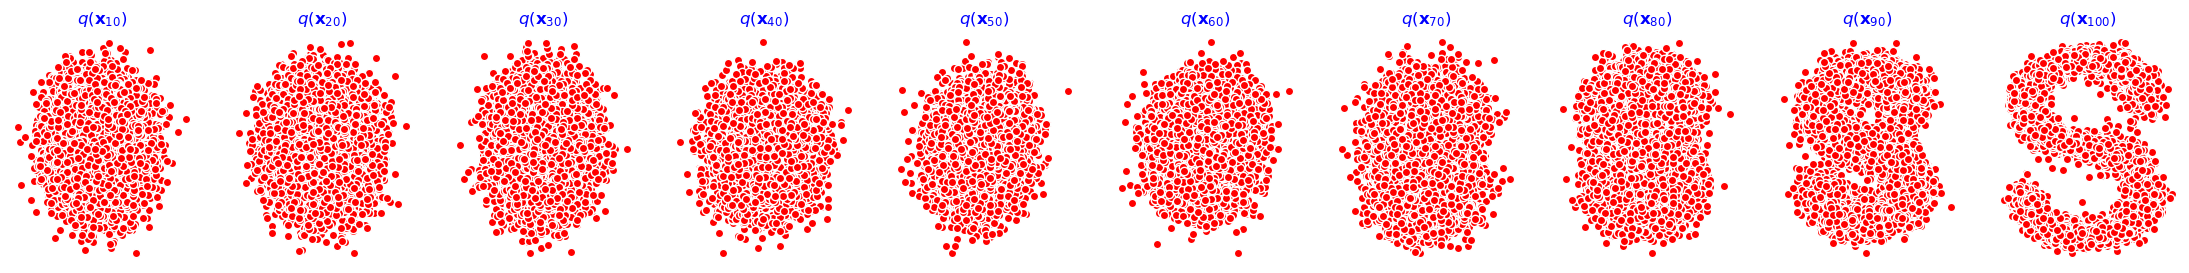

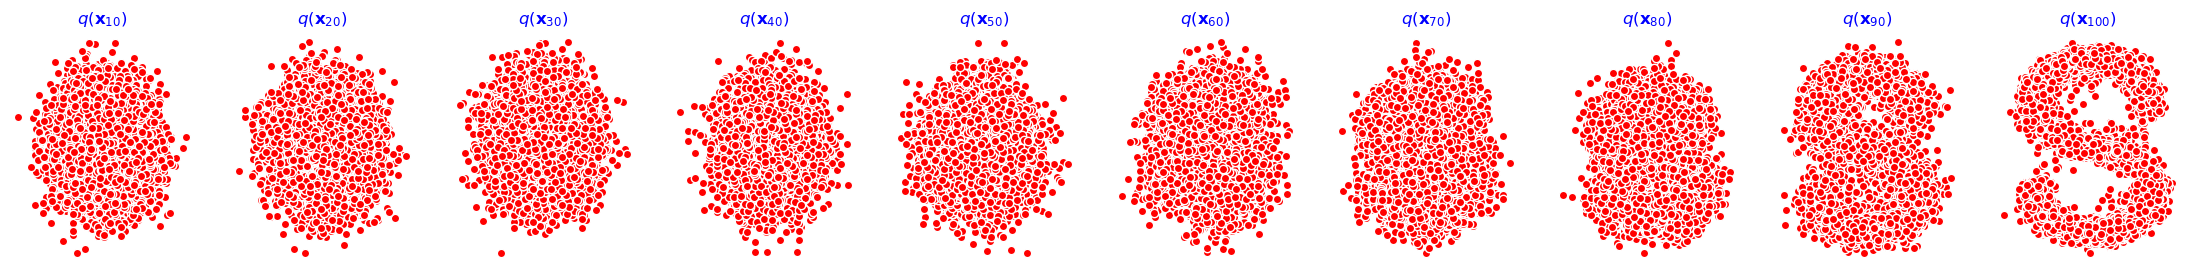

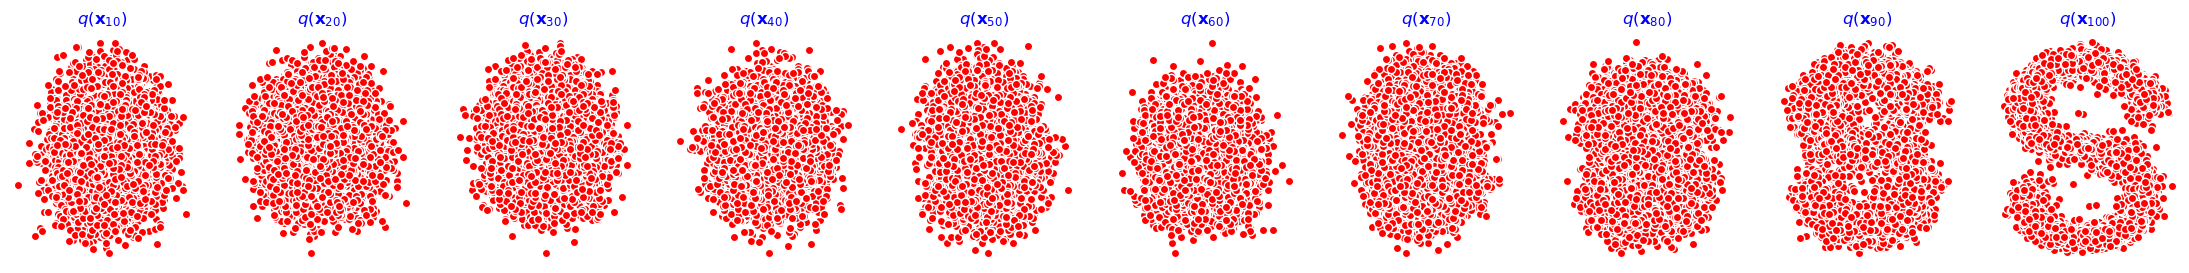

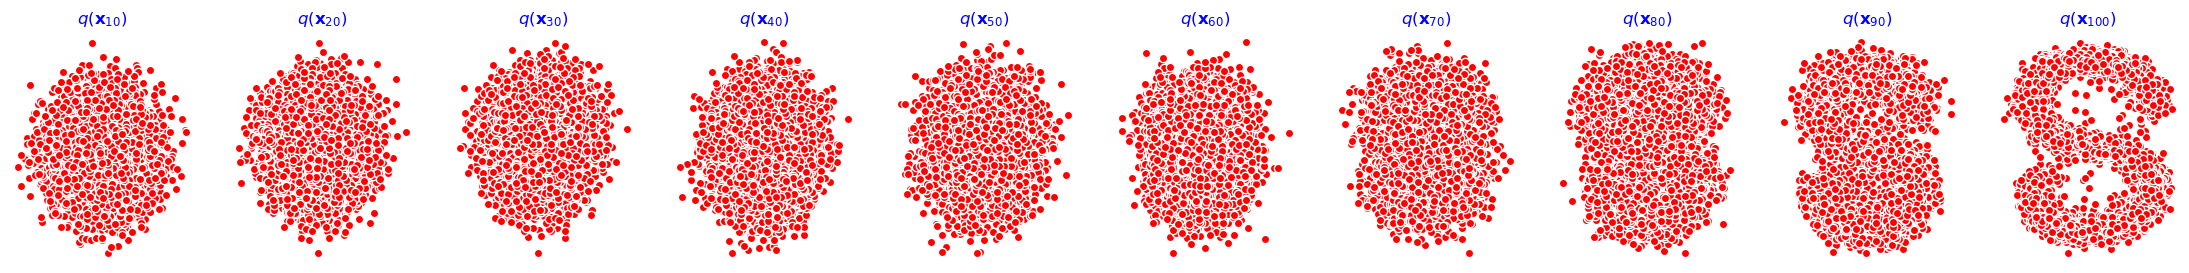

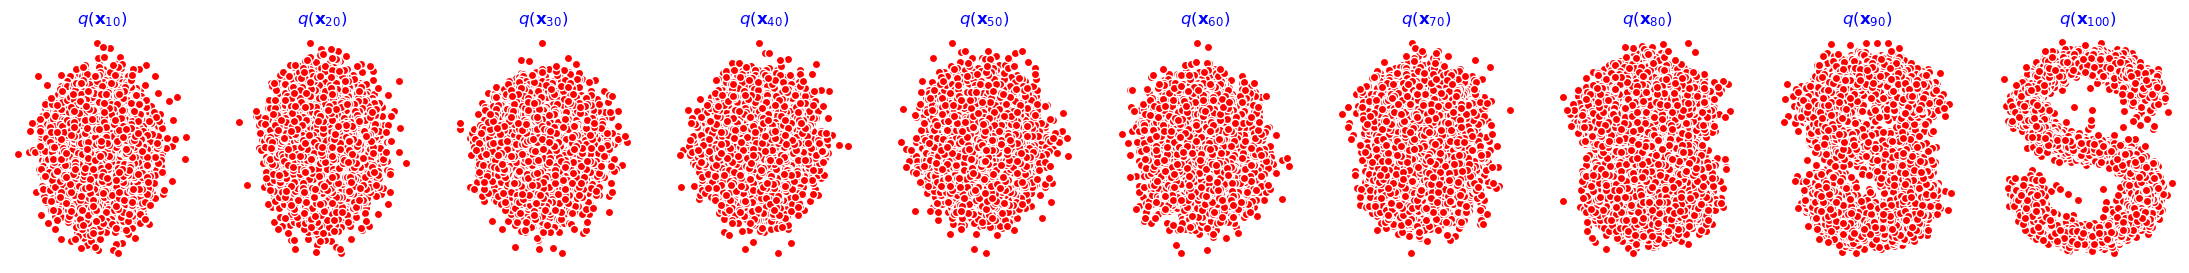

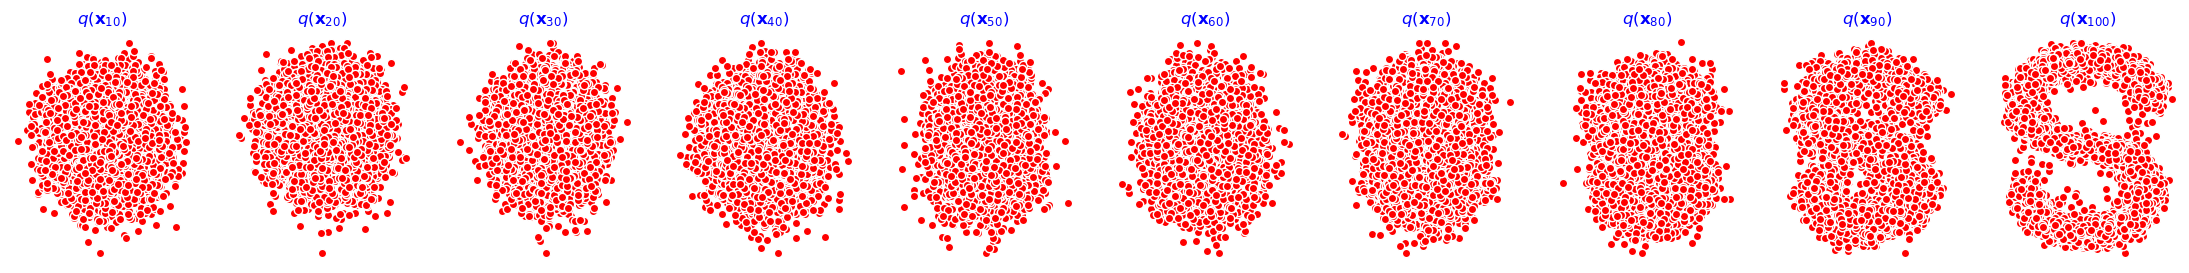

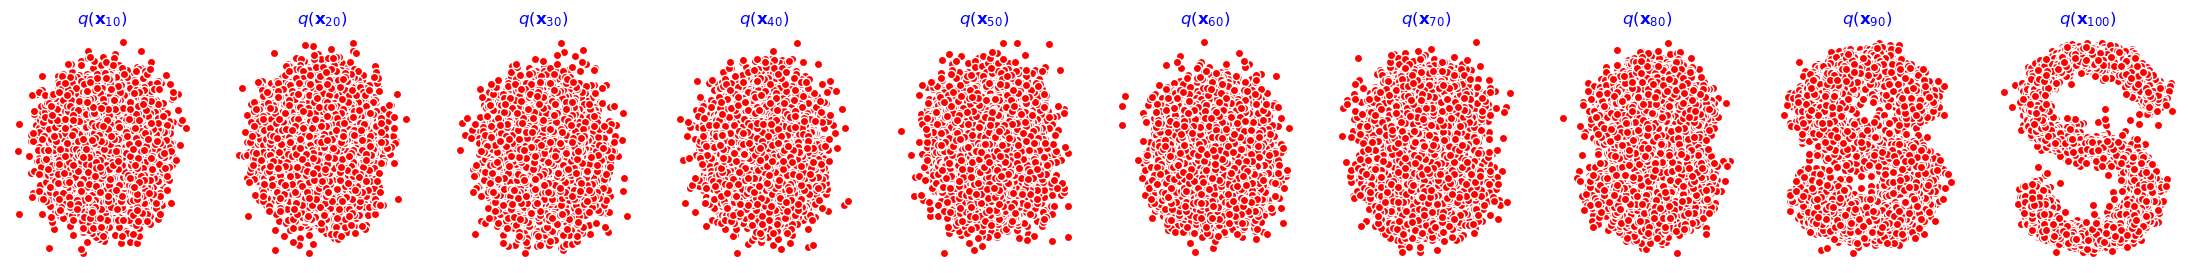

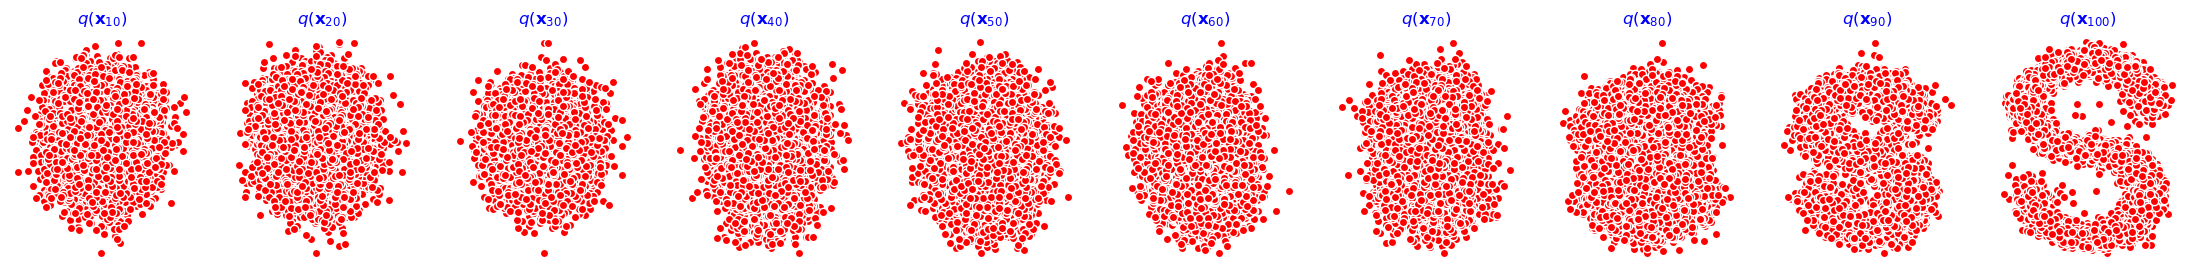

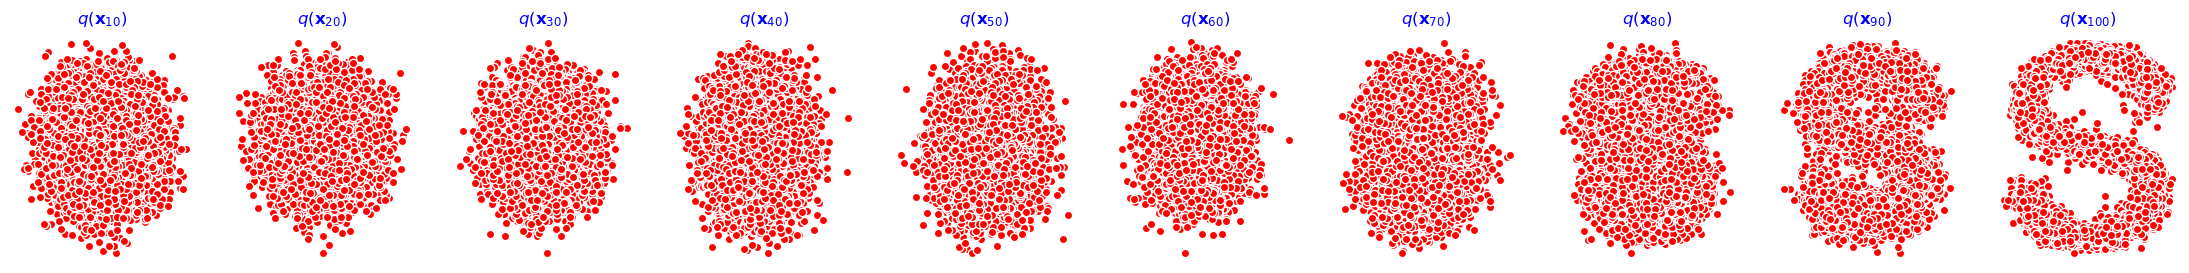

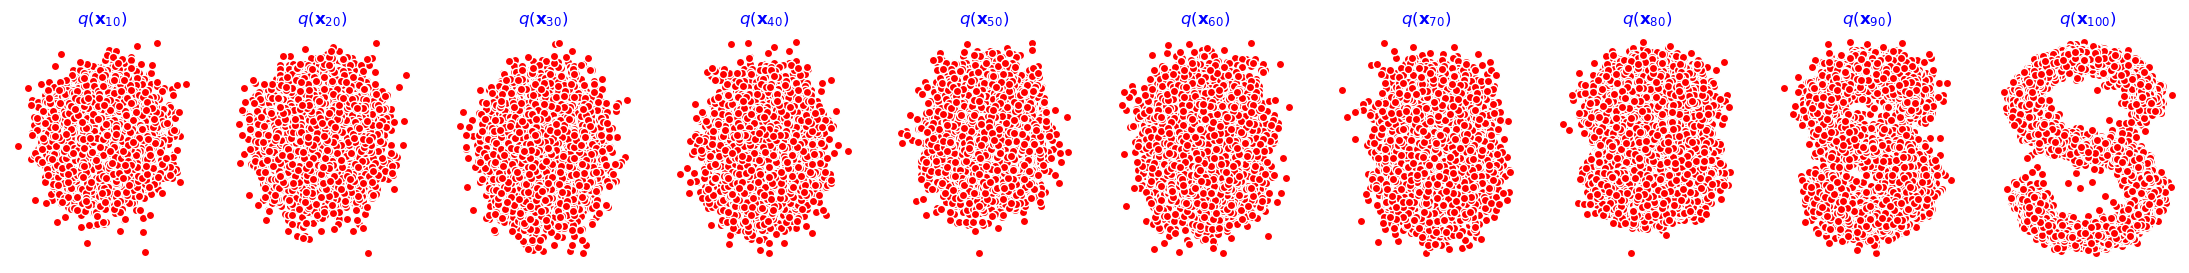

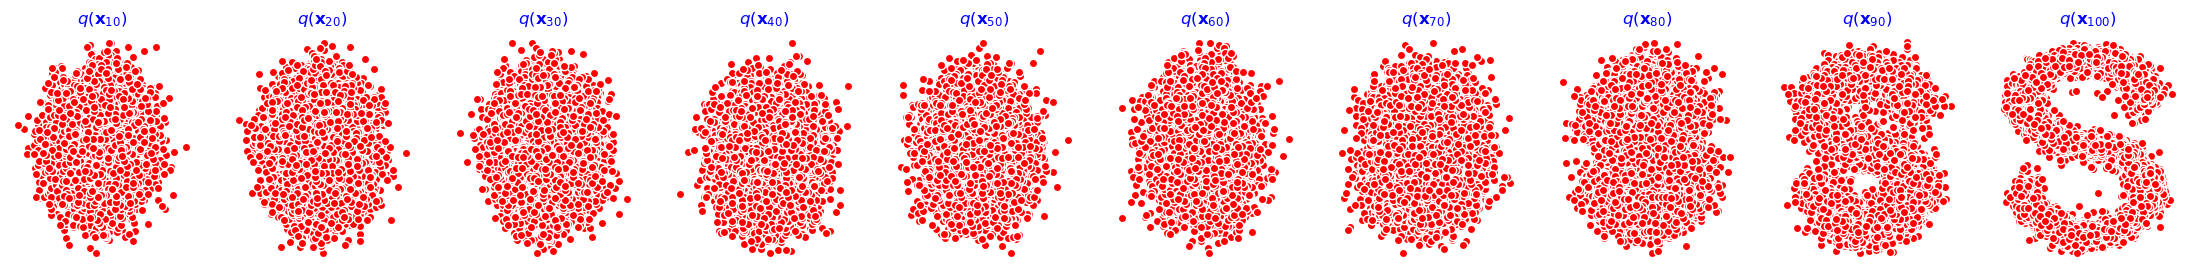

In [8]:
seed = 1234

class EMA():
    """构建一个参数平滑器"""
    def __init__(self,mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    
print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

动画演示扩散过程和逆扩散过程

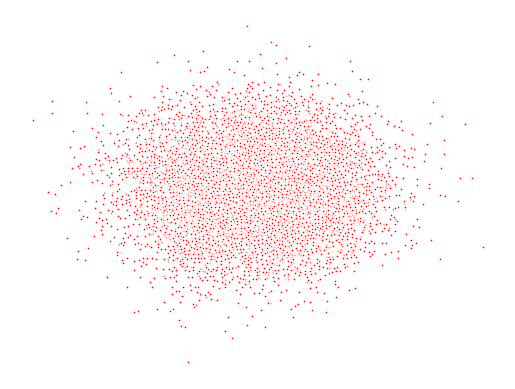

In [9]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset,torch.tensor([i]))
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off');
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

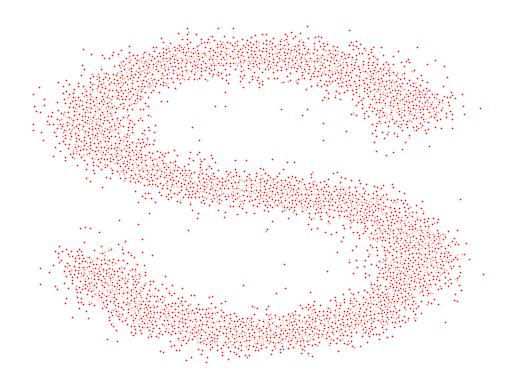

In [10]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [41]:
imgs = imgs +reverse

In [42]:
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)